# Finding the optimal portfolio allocation in a finite horizon setting using a target network

In [1]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from statsmodels.tsa.api import VAR
import random
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.optimize as sci
import seaborn as sns
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Functions to measure the performance

In [2]:
# calculates the max draw down
def max_draw_down(input_list):
    max_draw = np.inf
    for i in range(1, len(input_list)):
        draw_down = input_list[i] - input_list[i-1]
        if draw_down < max_draw:
            max_draw = draw_down
    return max_draw

# calculates the average return
def average_return(input_list, num_of_days):
    change = input_list[-1] - input_list[0]
    return change / (num_of_days/365)

# calcultates the standard deviation
def std_of_return(input_list):
    series = pd.Series(input_list).diff()
    return series.dropna().std()

def performance(input_list, num_of_days):
    print(f'average return: {round(average_return(input_list=input_list, num_of_days=num_of_days)*100,2)} p.a.%')
    print(f'max. draw down : {round(max_draw_down(input_list=input_list)*100,2)}%')
    print(f'Risk-return-ratio: {round(np.mean(pd.Series(input_list).diff())/std_of_return(input_list=input_list),2)}')
    print("")

In [3]:
# function findes in the array vec the entry with the highest values
# and returns are one-hot-encoded array where the 1 is in the position of the highest value

def find_best_dis(vec):
    order = np.argmax(vec)
    if order == 0:
        return [1, 0, 0]
    elif order == 1:
        return [0, 1, 0]
    elif order == 2:
        return [0, 0, 1]

In [4]:
def calc_return(df, i , prob):
    delta = (df.iloc[i+1,:] - df.iloc[i,:])/df.iloc[i,:] # percentage change
    period_return = delta[0:3].to_numpy().astype(float)
    #period_utility = crra_utility(period_return)
    weighted_period_utility = torch.multiply(torch.FloatTensor(period_return), prob )
    return weighted_period_utility

In [5]:
# convert q_values into probabilities
def softmax_function(array, temperature = 1):
    softm = torch.exp(array/temperature)/torch.sum(torch.exp(array/temperature))
    return softm

### Main Algorithm

In [6]:
# get data
df = pd.read_csv('../Data/20241010_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

# set date column as index
df.set_index('Date', inplace=True)
df.drop('UofM consumer sentiment', axis=1, inplace=True) # drop consumer confidence for now

df.drop('10y treasury Index', axis=1, inplace=True) # drop consumer confidence for now
ten_y_index = [100]
delta = -9.0/100.0
for i in range(len(df['10y'])-1):
    change_in_bp = (df['10y'][i+1] - df['10y'][i])/ df['10y'][i]
    ten_y_index.append(ten_y_index[i] + df['10y'][i]/(12) + change_in_bp * delta)

df['10y treasury Index'] = np.array(ten_y_index)


# split data in training and test set
split = 0.8
split_obs = int(df.shape[0] * split)
df_training = df[0:split_obs]
df_test = df[split_obs::]

data_rl_training = df_training[['SP500', 'Gold', '3M-Index', '10y treasury Index', 'CPI', 'Unemployment', 'non-farm payroll', 'WTI']]
data_rl_test = df_test[['SP500', 'Gold', '3M-Index', '10y treasury Index', 'CPI', 'Unemployment', 'non-farm payroll', 'WTI']]

# instantiate a standard scaler and scale data for RL model
standard_scaler = preprocessing.StandardScaler()
df_training_scaled = pd.DataFrame(standard_scaler.fit_transform(data_rl_training))
df_test_scaled = pd.DataFrame(standard_scaler.transform(data_rl_test))

# select data of all assets
data_all_assets_training = df_training[['SP500','Gold','3M-Index']].pct_change()
data_all_assets_test = df_test[['SP500','Gold','3M-Index']].pct_change()

In [7]:
# Hyperparameters
epochs = 30000 # number of experiments
patience = 8000
learning_rate = 0.001
delta = 0.9 # discount rate
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = (epsilon - epsilon_min)/(epochs/1) # half of epochs epsilon-greedy is effective
batch_size = 40
target_update_freq = 120 # frequency with which target net is updated
memory_size = 1000 # replay buffer from which randomly draw (state, action) pairs
#freq = 6
#temperature = 0.5

In [8]:
class NeuronalNet(nn.Module):
    def __init__(self, batch_size):
        # inherits from nn.Module
        # invoke initiator of parent class
        super().__init__()
        self.batch_size = batch_size
        # Set random seeds for reproducibility
        torch.manual_seed(42)      # PyTorch seed
        np.random.seed(42)         # NumPy seed
        random.seed(42)            # Python's random seed
    
    # define model
        l1 = 8 # inputs are numbers of time series plus counter for time horizon
        l2 = 75#20
        l3 = 75#60
        l4 = 3

        self.model = nn.Sequential(
            nn.Linear(l1,l2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(l2,l3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(l3, l4),
            nn.Softmax(dim=0)
        )
      
        # define loss function
        self.loss_function = nn.MSELoss()
        
        # define optimizer
        self.optimiser = torch.optim.Adam(self.parameters(), lr = learning_rate) 

        # counter and store loss
        self.counter = 0
        self.loss_out  = [np.inf]

    # forward pass
    def forward(self, inputs):
        return self.model(inputs)
    
    # trainings function
    def train(self, inputs, targets):
        # calc loss
        loss = self.loss_function(inputs, targets)
        # count and store loss
        self.counter += 1
        self.loss_out.append(loss.item())
        # learn
        self.optimiser.zero_grad() # optimizer reset
        loss.backward() # backpropagation
        self.optimiser.step() # re-adjust weights
       
    # return current loss
    def get_loss(self):
        return np.average(self.loss_out[- self.batch_size :])

In [9]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        return self.best_model_state

In [10]:
# initialize arrays to store results
portfolio_rl = []
portfolio_rl_corrected = []

profit_rl_list = [1]
profit_rl_list_corrected = [1]
profit_rl = 1
profit_rl_corrected = 1

sum_largest_prob = torch.zeros(3, dtype=float)
target_array = torch.zeros(3, dtype=float)


# initialize networks
policy_net = NeuronalNet(batch_size = batch_size)
target_net = NeuronalNet(batch_size = batch_size)
target_net.load_state_dict(policy_net.state_dict())

# instantiate early_stopping
early_stopping = EarlyStopping(patience=patience)

memory = deque(maxlen=memory_size) # special que where first entries drops out once more than maxlen entries are added

In [11]:
steps = df_training_scaled.shape[0] - 200 # start 200 months before end
counter = 0 # counter for time horizon, T = 120
state = df_training_scaled.iloc[steps,:].to_numpy().astype(float)
#state = np.append(state, counter)

for epoch in range(epochs):
    counter += 1
    next_state = df_training_scaled.iloc[steps + 1,:].to_numpy().astype(float)
    #next_state = np.append(next_state, counter)

    # policy network
    # epsilon-greedy
    if random.random() < epsilon: # Explore
        prob = torch.rand(3, requires_grad=False)
        prob /= torch.sum(prob) # normalize so that sum is equal to 1  
        action = prob

    else:       # Exploit
        q_values_policy = policy_net.forward(torch.from_numpy(state).float()) # q_values are action as well as they are probabilities
        #action = softmax_function(q_values_policy, temperature=temperature)
        action = q_values_policy

    # convert q_values into probabilities
    current_performance = data_all_assets_training.iloc[steps+1]
    next_performance = data_all_assets_training.iloc[steps+2]
    current_reward = action.detach() @ current_performance

    # Store transition in memory (state, action, reward, next_state, current_payoff, next_payoff)
    memory.append((state, action, current_reward, next_state, counter))
    
    # Update state
    state = next_state
    
    if len(memory) >= batch_size: # train policy network
        batch = random.sample(memory, batch_size)
        state_batch = [s1 for (s1,a,r,s2, step) in batch]
        state_batch_np = np.array(state_batch)  
        # Convert the numpy array to a PyTorch tensor
        state_batch = torch.tensor(state_batch_np, dtype=torch.float32)
        action_batch = [a.detach() for (s1,a,r,s2,step) in batch]
        reward_batch = torch.Tensor([r for (s1,a,r,s2,step) in batch])
        next_state_batch = [s2 for (s1,a,r,s2, step) in batch]
        next_state_batch_np = np.array(next_state_batch)
        next_state_batch = torch.tensor(next_state_batch_np, dtype=torch.float32)
        step = [step for (s1,a,r,s2,step) in batch]

        # Compute Q-values for current states with policy network
        q_values = policy_net(state_batch)
        prob = torch.cat(action_batch).view(batch_size,-1)
        #result = torch.sum(q_values * prob , dim=1).view(-1, 1).squeeze()
        result = torch.sum(q_values, dim=1).view(-1, 1).squeeze()

        # check if T already reached
        cond = [int(x <= 120) for x in step]
        #convert condition into tensor of 1s and 0s
        

        with torch.no_grad():
                cond_tensor = torch.tensor(cond, dtype=torch.float32).reshape(batch_size, 1)
                max_next_q_values = target_net(next_state_batch).max(1)[0] 
                # if T is reached max_next_q_values is set to zero
                temp = max_next_q_values.reshape(batch_size, 1) * cond_tensor  
                target_q_values = reward_batch + delta * temp.squeeze(-1)

        policy_net.train(result, target_q_values)


    # Update target network periodically
    if steps % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())
    

    # iterate over entire data
    if steps < df_training_scaled.shape[0] - 3:
        steps += 1
    else:
        steps = 0
        counter = 0

    # call early stopping    
    early_stopping(policy_net.get_loss(), policy_net)

    if early_stopping.early_stop:
        print("Early Stop!")
        break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon - epsilon_decay)

# if early stopping is true load the best parameters of the policy network for the target network
if early_stopping.early_stop:
    target_net.load_state_dict(early_stopping.load_best_model(policy_net))



#apply trained model to test data
for i in range(1, data_all_assets_test.shape[0]):
# performance of assets
    perf_all_assets = data_all_assets_test.iloc[i,:] 

    
    # get data for nn model
    state = pd.DataFrame(df_test_scaled).iloc[i,:].to_numpy().astype(float)
    #state = np.append(state, i)
    q_values_target = target_net.forward(torch.from_numpy(state).float()) # q_values are action as well as they are probabilities
    prob = q_values_target

    # store the weights of the portfolios
    probability = prob.detach().numpy()
    probability_corrected = np.array([probability[0]+(probability[0]/(probability[0]+probability[1]))*(probability[2]-0.25),probability[1]+(probability[1]/(probability[0]+probability[1]))*(probability[2]-0.25), 0.25])

    # store probabilities
    portfolio_rl.append(probability)
    portfolio_rl_corrected.append(probability_corrected)


    # calculate profit for RL
    profit_rl += perf_all_assets@prob.detach().numpy()
    profit_rl_corrected += perf_all_assets@probability_corrected
    profit_rl_list.append(profit_rl) 
    profit_rl_list_corrected.append(profit_rl_corrected) 


Early Stop!


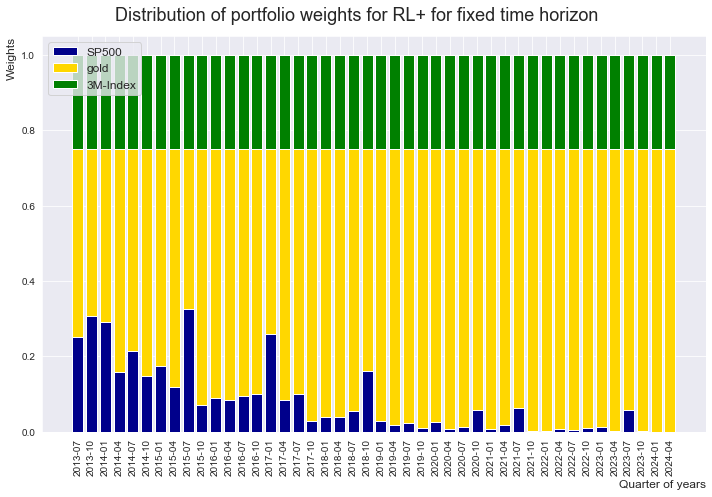

In [22]:
# labels
categories = ['SP500','gold','3M-Index']
names = ['MPT','TS', 'RL']

portfolio_rl_list = [tensor.tolist() for tensor in portfolio_rl_corrected]

portfolios = [portfolio_rl_list]

 # set-up graphic
sns.set_style('darkgrid')
fig, ax = plt.subplots(len(portfolios), 1, figsize=(10, 7))



container = []
x_axis = []
for i in range(0,132,3):
    container.append(portfolio_rl_list[i])
    x_axis.append(data_all_assets_test.index[1+i].strftime('%Y-%m'))

# x- axis
n_timepoints = len(container)
x = np.arange(n_timepoints)

# define colours
colors = ['darkblue', 'gold', 'green', 'red']

# bars starting at zero
bottom = np.zeros(n_timepoints)

# stacked bar chart
for i, category in enumerate(categories):
    heights = [probabilities[i] for probabilities in container]
    ax.bar(x, heights, bottom=bottom, label=category, color=colors[i])
    # Update der 'bottom'-Positionen für das nächste Segment
    bottom += heights



    # labelling of axis
    ax.set_xlabel('Quarter of years', loc='right', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(x_axis, fontsize=10, rotation=90)
    ax.set_ylabel('Weights',loc='top', fontsize=12)
    #ax.set_title(f'Distribution of Portfolio Weights of RL over time', fontsize=12)

    # add legend 
    ax.legend( loc=2, fontsize=12)

plt.suptitle('Distribution of portfolio weights for RL+ for fixed time horizon', fontsize = 18)
plt.tight_layout()
plt.show()